#### 1. 数据加载
#### 2. 特征工程-降维
##### 2.1 PCA
##### 2.2 SVD
#### 3. XGBoost 增量学习

#### 1.数据加载

In [2]:
# 加载100000万数据
!ls /work/datasets/

ddos_balanced.7z	unbalaced_20_80_dataset.csv
ddos_imbalanced.7z	unbalaced_test.csv
train_triplets.txt.zip	yelp_academic_dataset_business.json.zip


In [2]:
import numpy as np
import pandas as pd


def get_data_set(file_path):

    ddos_data = pd.read_csv(file_path, low_memory=False)
    # 暂时剔除无意义的特征
    del ddos_data['Row']
    # 删除非数值列
    other_data = ddos_data.drop([
        'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
        'Timestamp'
    ],
                                axis=1)
    # 删除空值
    other_data = other_data.dropna(how='all')
    # 转换为numpy  aarray
    new_data = other_data.to_numpy()
    # 拆分特征列和目标列
    X, y = new_data[:, :-1], new_data[:, -1]
    # 数值型转换类型
    X = X.astype(float)
    # 处理nan or inf
    X = np.nan_to_num(X)
    return X, y

In [3]:
file = "/work/datasets/unbalaced_test.csv"
X,y = get_data_set(file)

In [5]:
X.shape

(100009, 76)

In [7]:
X[0],y[0]

(array([ 8.66000000e+03,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.30946882e+02,  8.66000000e+03,
         0.00000000e+00,  8.66000000e+03,  8.66000000e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.20000000e+01,  3.20000000e+01,  1.15473441e+02,
         1.15473441e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.0

In [8]:
# 基本数据特征处理
def max_min_sc(X):
    # 特征归一化处理
    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(X)


def label_encoder(y):
    # 标签数值化，方便处理
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    return le.fit_transform(y)

In [9]:
y = label_encoder(y)
X = max_min_sc(X)

/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
def split_X_y(X, y):
    # 拆分数据集
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=2019)
    return X_train, X_test, y_train, y_test

In [11]:
def classify_re(y_test, y_pred):
    #准确率
    from sklearn.metrics import classification_report
    return classification_report(y_test, y_pred)

In [12]:
def knn_model(X_train, y_train):
    from sklearn.neighbors import KNeighborsClassifier
    # 需要全部转换为数值型
    knn = KNeighborsClassifier(n_neighbors=6,
                               weights='uniform',
                               algorithm='auto',
                               leaf_size=30,
                               p=2,
                               metric='minkowski',
                               metric_params=None,
                               n_jobs=10)
    knn.fit(X_train, y_train)
    return knn

In [16]:
X_train, X_test, y_train, y_test =split_X_y(X,y)

In [19]:
knn = knn_model(X_train, y_train)
y_pred = knn.predict(X_test)

In [20]:
print(classify_re(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4058
           1       1.00      1.00      1.00     15944

    accuracy                           1.00     20002
   macro avg       1.00      1.00      1.00     20002
weighted avg       1.00      1.00      1.00     20002



#### 2.1 PCA 降维

In [21]:
# 保留80% 指标
76*0.8

60.800000000000004

In [61]:
def pca_data(X, n_components=60, random_state=2019):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=60,
              copy=True,
              whiten=False,
              svd_solver='auto',
              tol=0.0,
              iterated_power='auto',
              random_state=2019)
    return pca.fit_transform(X)

In [25]:
# 重新获取未归一化处理的特征
X0,_=get_data_set(file)

In [26]:
X0_train, X0_test, _, _ = split_X_y(X0, y)

In [27]:
%%time
knn = knn_model(X0_train, y_train)
y0_pred = knn.predict(X0_test)

/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/work/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow e

CPU times: user 10.8 s, sys: 669 ms, total: 11.5 s
Wall time: 13.4 s


In [28]:
# 不进行归一化的数据，准确率下降 0.01，估计降维不会提升多少，主要看计算量耗时
print(classify_re(y_test,y0_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4058
           1       0.99      0.99      0.99     15944

    accuracy                           0.99     20002
   macro avg       0.99      0.99      0.99     20002
weighted avg       0.99      0.99      0.99     20002



In [62]:
# test
# array must not contain infs or NaNs???
## a.dtype.char in typecodes['AllFloat']??
## 与数据有关系？数据需要归一化？
from sklearn import datasets
digits=datasets.load_digits()
X_d,y_d=digits.data,digits.target

pca=PCA(n_components=30)
pca.fit(X_d)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [69]:
# 果然数据需要归一化
X_pca=pca_data(X)

In [70]:
# 查看降维后的数据情况
X_pca

array([[-5.27506218e-01, -7.79279153e-02, -1.09509327e-01, ...,
         6.80710432e-07, -4.91338504e-08, -4.87370552e-07],
       [ 1.52875113e+00, -6.56519938e-01,  2.10020624e-02, ...,
        -3.73061528e-06,  8.92862507e-07,  3.10003661e-06],
       [-4.54508031e-01, -1.08045814e-01, -2.45265923e-01, ...,
         1.30107861e-05, -4.98267298e-07,  5.10095804e-06],
       ...,
       [ 5.95054504e-02,  2.07065990e-01, -2.88975189e-01, ...,
        -5.66954798e-06, -4.72344208e-06, -6.16553857e-07],
       [ 5.98949577e-02,  2.07083736e-01, -2.88400427e-01, ...,
        -5.02737248e-06, -4.36756279e-06, -7.98876324e-07],
       [-5.07723425e-01,  4.79805137e-02, -9.69539043e-02, ...,
         3.06830303e-05, -1.97575642e-05, -1.85265738e-06]])

In [72]:
%%time
# 训练降维后的数据
X_pca_train, X_pca_test, _, _ =split_X_y(X_pca,y)
knn = knn_model(X_pca_train, y_train)
y_pca_pred = knn.predict(X_pca_test)

CPU times: user 7.93 s, sys: 2.04 s, total: 9.97 s
Wall time: 11.9 s


In [73]:
print(classify_re(y_pca_pred,y_test))  # 准确率提升不大，但是计算时间提高了50%

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4055
           1       1.00      1.00      1.00     15947

    accuracy                           1.00     20002
   macro avg       1.00      1.00      1.00     20002
weighted avg       1.00      1.00      1.00     20002



##### 2.2 SVD 奇异值分解同理
>主要观察计算时间时效 
>准确率提高需要增加更多数据


#### 在线(增量)学习
1. 针对于计算资源有限的情况下，能够快速添加新数据进行训练
2. Xgboost提供两种增量训练的方式:
> 1) 在当前迭代树的基础上增加新树，原树不变  
> 2) 当前迭代树结构不变，重新计算叶节点权重，同时也可增加新树

In [93]:
### demo test
# https://github.com/dmlc/xgboost/blob/master/tests/python/test_training_continuation.py
import xgboost as xgb
# use digits dataset
Xd_train, Xd_test, yd_train, yd_test = split_X_y(X0, y_d)

In [97]:
# base xgboost interface
d_train=xgb.DMatrix(Xd_train,yd_train)
xgb_model=xgb.train({},d_train)

In [134]:
def xgb_model(X_train, y_train):
    xgb_model_sk = xgb.XGBClassifier(max_depth=5,
                                     learning_rate=0.1,
                                     n_estimators=160,
                                     verbosity=1,
                                     silent=True,
                                     objective='binary:logistic',
                                     booster='gbtree',
                                     n_jobs=1,
                                     nthread=None,
                                     gamma=0,
                                     min_child_weight=1,
                                     max_delta_step=0,
                                     subsample=1,
                                     colsample_bytree=1,
                                     colsample_bylevel=1,
                                     colsample_bynode=1,
                                     reg_alpha=0,
                                     reg_lambda=1,
                                     scale_pos_weight=1,
                                     base_score=0.5,
                                     random_state=0,
                                     seed=None,
                                     missing=None)
    xgb_model_sk.fit(X_train, y_train)
    return xgb_model_sk

In [135]:
ddos_data_model=xgb_model(X_pca_train,y_train)

In [104]:
yd_pred_sk=xgb_model_sk.predict(Xd_test)

In [105]:
print(classify_re(yd_test, yd_pred_sk))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       0.97      1.00      0.99        37
           2       1.00      1.00      1.00        33
           3       1.00      0.93      0.96        42
           4       1.00      1.00      1.00        32
           5       1.00      0.90      0.95        39
           6       0.98      0.98      0.98        41
           7       1.00      0.97      0.98        33
           8       0.95      1.00      0.97        36
           9       0.86      0.97      0.91        33

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



In [118]:
### 针对我们源数据, xgboost 计算耗时，准确度高， 相比其他算法
ddos_data_model = xgb_model(X_pca_train, y_train)

In [138]:
y_pca_pred = ddos_data_model.predict(X_pca_test)
print(classify_re(y_test,y_pca_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4058
           1       1.00      1.00      1.00     15944

    accuracy                           1.00     20002
   macro avg       1.00      1.00      1.00     20002
weighted avg       1.00      1.00      1.00     20002



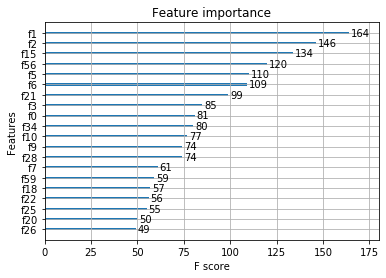

In [139]:
# 特征重要性
from matplotlib import pyplot as plt
%matplotlib inline
xgb.plot_importance(ddos_data_model,max_num_features=20)

In [ ]:
## 各种树的对比
https://zhuanlan.zhihu.com/p/33700459